In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

# 基本參數
c = 3e8                 # 光速 (m/s)
fc = 77e9               # 載頻 (Hz)
Tc = 10e-6              # Chirp 時長 (s)
fs = 25.6e6             # 取樣率 (Hz)
bw = 500e6              # FMCW 帶寬 (Hz)
k = bw / Tc             # Chirp 斜率
lambda_c = c / fc       # 波長 (m)

# 取樣點與時間
Ns = 256
t = np.arange(Ns) / fs

# 多個 chirp
P = 256                 # chirp 數
chirp_idx = np.arange(P)

# MIMO 陣列參數
M = 4  # Rx 天線
N = 3  # Tx 天線
d = lambda_c / 2

# 模擬單一目標 (人)
R = 4                   # 距離 4 m
vx = 0                # VX = -20 m/s（靠近）
vy = -20                  # VY = 0 m/s（無橫向）
theta = 0               # 假設正前方入射角

# Doppler 與 beat frequency
fd = 2 * vx * fc / c    # Doppler 頻率
fb = 2 * k * R / c      # Beat 頻率

# 訊號強度與雜訊
SNR_dB = 15
Np = 1                  # noise power
An = np.sqrt(Np)
Sp = Np * 10**(SNR_dB / 10)
As = np.sqrt(Sp)

# 初始化 ADC 資料: (M*N, P, Ns)
adc_data = np.zeros((M * N, P, Ns), dtype=complex)

# 建立發射與接收陣列座標
tx_pos = np.arange(N) * d
rx_pos = np.arange(M) * d

# 開始模擬資料
for n in range(N):          # Tx loop
    for m in range(M):      # Rx loop
        idx = n * M + m     # 通道編號
        # 相位延遲 (AoA/AoD)
        phase_shift = 2 * np.pi * (tx_pos[n] + rx_pos[m]) * np.sin(np.deg2rad(theta)) / lambda_c
        
        for p in range(P):  # chirp index
            doppler_phase = 2 * np.pi * fd * p * Tc
            signal = As * np.exp(1j * (2 * np.pi * fb * t + doppler_phase + phase_shift))
            noise = An * (np.random.randn(Ns) + 1j * np.random.randn(Ns)) / np.sqrt(2)
            adc_data[idx, p, :] = signal + noise
            
# 儲存為 .npy 檔案
adc_path = "adc_data.npy"
np.save(adc_path, adc_data)


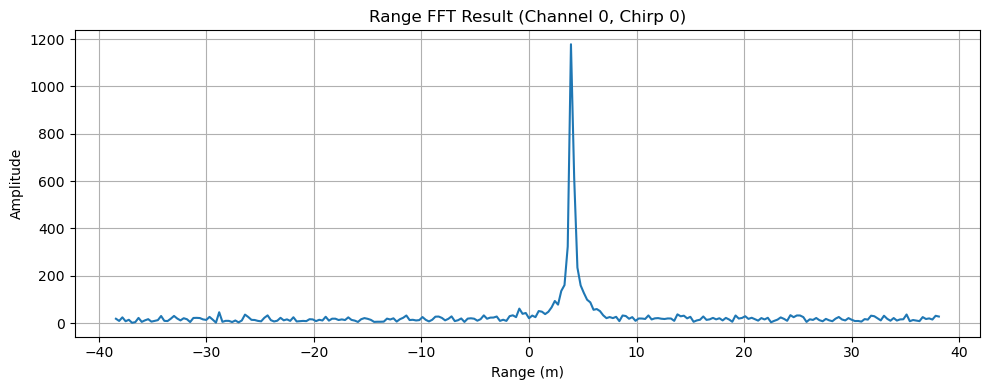

In [36]:
# 對每個虛擬天線、每個 chirp 做 Range FFT（沿著 time/sample 軸進行）
# 輸出 shape: (12 虛擬天線, 256 chirps, 256 range bins)
range_cube = np.fft.fft(adc_data, axis=-1)
range_cube = np.fft.fftshift(range_cube, axes=-1)  # 將頻域中心化（方便觀察）

# 選擇一條虛擬天線與一個 chirp 做範例顯示
example_channel = 0
example_chirp = 0
range_profile = np.abs(range_cube[example_channel, example_chirp, :])

# 製作 range axis（對應距離的 x 軸）
range_res = c / (2 * bw)  # range resolution
range_axis = (np.arange(Ns) - Ns//2) * range_res  # 中心化

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(range_axis, range_profile)
plt.title(f"Range FFT Result (Channel {example_channel}, Chirp {example_chirp})")
plt.xlabel("Range (m)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


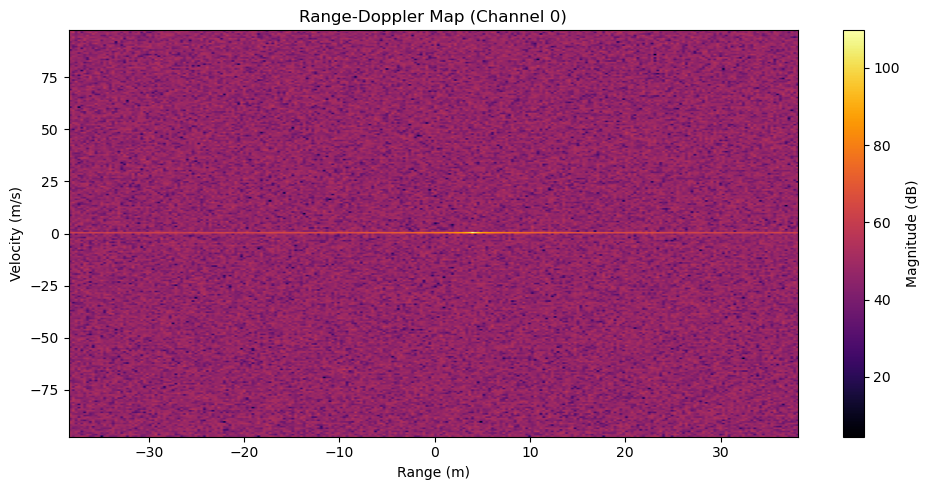

In [37]:
# 對每個天線、每個 range bin 做 Doppler FFT（沿 chirp 軸）
# Input: range_cube (12, 256 chirps, 256 range bins)
# Output: doppler_cube (12, 256 Doppler bins, 256 range bins)

doppler_cube = np.fft.fft(range_cube, axis=1)
doppler_cube = np.fft.fftshift(doppler_cube, axes=1)  # 中心化頻率軸

# 選擇一個天線通道進行視覺化（Range-Doppler 圖）
example_channel = 0
rd_matrix = np.abs(doppler_cube[example_channel])

# 設定 Doppler 速度軸
v_max = c / (4 * fc * Tc)  # 近似最大速度（Nyquist）
doppler_axis = np.linspace(-v_max, v_max, P)
range_axis = (np.arange(Ns) - Ns//2) * c / (2 * bw)

plt.figure(figsize=(10, 5))
plt.imshow(20 * np.log10(rd_matrix + 1e-6), extent=[range_axis[0], range_axis[-1], doppler_axis[0], doppler_axis[-1]],
           aspect='auto', origin='lower', cmap='inferno')
plt.title(f"Range-Doppler Map (Channel {example_channel})")
plt.xlabel("Range (m)")
plt.ylabel("Velocity (m/s)")
plt.colorbar(label='Magnitude (dB)')
plt.tight_layout()
plt.show()


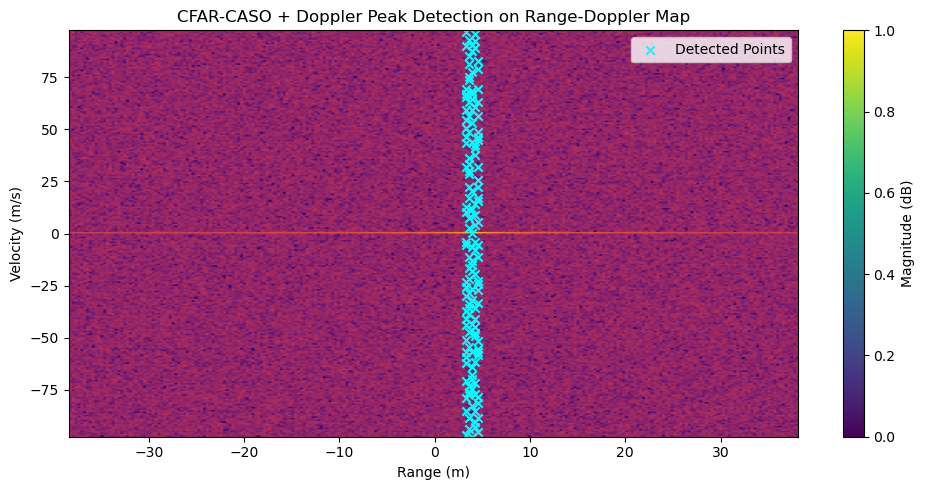

In [38]:
import scipy.ndimage

def cfar_caso_1d(signal, guard_cells=4, noise_cells=8, threshold_scale=6.0):
    """
    1D CFAR-CASO detector applied along range axis for one Doppler bin.
    """
    N = len(signal)
    detected = np.zeros(N, dtype=bool)

    for idx in range(noise_cells + guard_cells, N - noise_cells - guard_cells):
        leading_noise = signal[idx - noise_cells - guard_cells:idx - guard_cells]
        lagging_noise = signal[idx + guard_cells + 1:idx + guard_cells + noise_cells + 1]
        noise_level = (np.sum(leading_noise) + np.sum(lagging_noise)) / (2 * noise_cells)

        threshold = noise_level * threshold_scale
        if signal[idx] > threshold:
            detected[idx] = True

    return detected

# 從 Doppler map 中，選出每個 range bin 上最大 Doppler FFT bin 的能量
rd_power = np.abs(doppler_cube[0])**2
range_profile_power = np.max(rd_power, axis=0)

# 1. 在 range 上做 CFAR-CASO
cfar_range_detect = cfar_caso_1d(range_profile_power)

# 2. 在 Doppler 上找 local peak（使用 scipy maximum_filter）
peak_map = (rd_power == scipy.ndimage.maximum_filter(rd_power, size=(3, 3)))  # 3x3 區域極大值
rd_detect_map = np.zeros_like(rd_power, dtype=bool)

for r in np.where(cfar_range_detect)[0]:
    rd_detect_map[:, r] = peak_map[:, r]

# 3. 找出偵測點（符合 CFAR + 是 Doppler peak）
detected_points = np.argwhere(rd_detect_map)
detected_mags = rd_power[detected_points[:, 0], detected_points[:, 1]]

# 4. Interpolation (這裡簡化為最大值，不進行 sub-bin interpolation)
# 5. 依 range index 做排序
sorted_indices = np.argsort(detected_points[:, 1])  # sort by range bin
sorted_points = detected_points[sorted_indices]
sorted_mags = detected_mags[sorted_indices]

import pandas as pd
df_detected = pd.DataFrame({
    "doppler_bin": sorted_points[:, 0],
    "range_bin": sorted_points[:, 1],
    "magnitude": sorted_mags
})
# import ace_tools as tools; tools.display_dataframe_to_user(name="CFAR Detected Points", dataframe=df_detected)

# 視覺化偵測結果在 Range-Doppler Map 上

plt.figure(figsize=(10, 5))
plt.imshow(20 * np.log10(rd_power + 1e-6), extent=[range_axis[0], range_axis[-1], doppler_axis[0], doppler_axis[-1]],
           aspect='auto', origin='lower', cmap='inferno')
plt.scatter(
    range_axis[sorted_points[:, 1]], 
    doppler_axis[sorted_points[:, 0]], 
    color='cyan', marker='x', label='Detected Points'
)
plt.title("CFAR-CASO + Doppler Peak Detection on Range-Doppler Map")
plt.xlabel("Range (m)")
plt.ylabel("Velocity (m/s)")
plt.colorbar(label='Magnitude (dB)')
plt.legend()
plt.tight_layout()
plt.show()


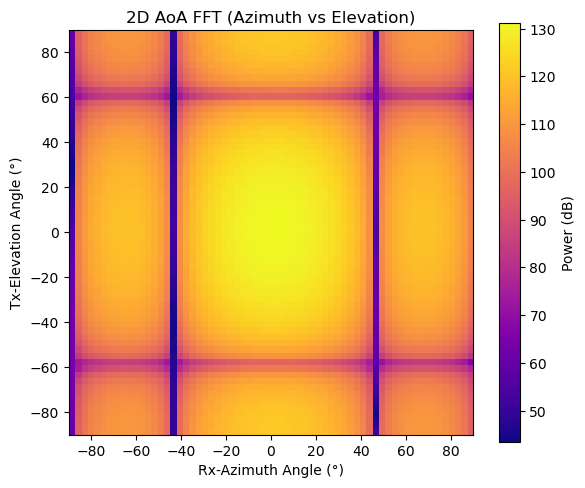

In [39]:
# 對每一個偵測點 (range_bin, doppler_bin)，取出該點對應的 12 天線值，重建虛擬天線陣列 (3 Tx × 4 Rx)
# 然後做 2D FFT 來估計角度 (Azimuth & Elevation)

# 虛擬陣列形狀：3 (Tx) × 4 (Rx)
tx_ant = 3
rx_ant = 4

# 建立空間頻率軸
angle_bins = 64
angles = np.arcsin(np.linspace(-1, 1, angle_bins)) * 180 / np.pi  # -90 ~ +90 degrees

# 記錄所有角度 FFT 結果 (每個偵測點 2D FFT)
angle_maps = []

for doppler_bin, range_bin in sorted_points[:, [0, 1]]:
    # 取出所有虛擬天線上的值：adc_data shape = (12, chirp, sample)
    # range_cube shape = (12, chirp, range_bin)
    # doppler_cube shape = (12, doppler_bin, range_bin)
    antenna_values = doppler_cube[:, doppler_bin, range_bin]  # shape: (12,)
    antenna_array = antenna_values.reshape((tx_ant, rx_ant))  # shape: (3, 4)

    # 做 2D FFT
    aoa_fft = np.fft.fft2(antenna_array, s=(angle_bins, angle_bins))
    aoa_fft = np.fft.fftshift(np.abs(aoa_fft))
    angle_maps.append(aoa_fft)

# 視覺化第一個角度圖 (對應最大 magnitude 的點)
best_idx = np.argmax(sorted_mags)
angle_map = angle_maps[best_idx]

plt.figure(figsize=(6, 5))
plt.imshow(20 * np.log10(angle_map + 1e-6), extent=[-90, 90, -90, 90], origin='lower', cmap='plasma')
plt.xlabel("Rx-Azimuth Angle (°)")
plt.ylabel("Tx-Elevation Angle (°)")
plt.title("2D AoA FFT (Azimuth vs Elevation)")
plt.colorbar(label="Power (dB)")
plt.tight_layout()
plt.show()


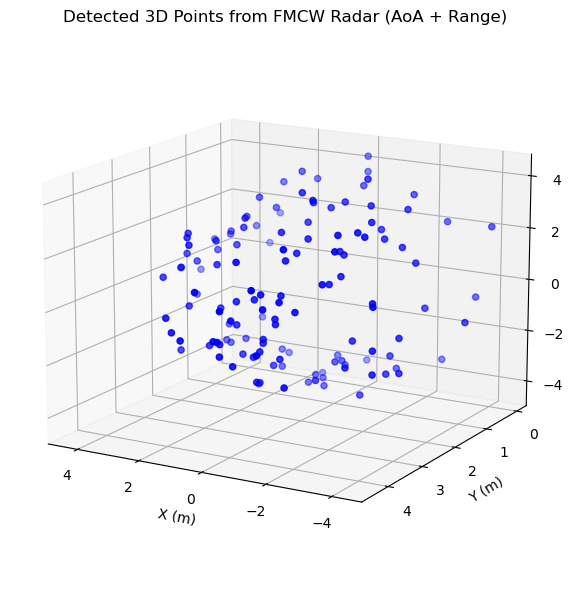

In [40]:
# 將每個 AoA FFT 圖中的主峰位置轉換為 Azimuth 與 Elevation 角度
peak_angles = []

for angle_map in angle_maps:
    peak_idx = np.unravel_index(np.argmax(angle_map), angle_map.shape)
    ele_idx, azi_idx = peak_idx
    azimuth = angles[azi_idx]
    elevation = angles[ele_idx]
    peak_angles.append((azimuth, elevation))

# 計算 Range（由 range bin 得到）
range_bins = sorted_points[:, 1]
ranges = (range_bins - Ns//2) * (c / (2 * bw))  # range axis中心化

# 根據 Range, Azimuth, Elevation 計算 (X, Y, Z)
xyz_points = []
for (azi, ele), R in zip(peak_angles, ranges):
    azi_rad = np.deg2rad(azi)
    ele_rad = np.deg2rad(ele)
    x = R * np.cos(ele_rad) * np.sin(azi_rad)
    y = R * np.cos(ele_rad) * np.cos(azi_rad)
    z = R * np.sin(ele_rad)
    xyz_points.append((x, y, z))

xyz_points = np.array(xyz_points)

# 畫出 3D 點雲圖
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_points[:, 0], xyz_points[:, 1], xyz_points[:, 2], c='blue', marker='o')

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("Detected 3D Points from FMCW Radar (AoA + Range)")
ax.view_init(elev=15, azim=120)
plt.tight_layout()
plt.show()


In [41]:
detected_doppler_bins = sorted_points[:, 0]
detected_velocities = doppler_axis[detected_doppler_bins]

# 訊號強度使用每個點的虛擬天線能量平均
mags_db = 10 * np.log10(np.mean(np.abs(antenna_values)**2))

# 噪聲改為 Doppler map 的非目標點能量平均
noise_floor = np.mean(rd_power[np.where(rd_power < np.percentile(rd_power, 80))])

detected_snr_db = mags_db - 10 * np.log10(noise_floor)

# 整理成 dataframe 顯示
df_result = pd.DataFrame({
    "X (m)": xyz_points[:, 0],
    "Y (m)": xyz_points[:, 1],
    "Z (m)": xyz_points[:, 2],
    "Velocity (m/s)": detected_velocities,
    "SNR (dB)": detected_snr_db
})


# 重新使用原始 ADC 資料來估算真實 Doppler 頻率（速度）
# 方法：在偵測點的 range bin 上，取出所有 chirp 上的相位 → 做 FFT → 估計 Doppler 頻率

true_velocities = []

for doppler_bin, range_bin in sorted_points[:, [0, 1]]:
    # 從 adc_data 中取出每個通道對應 range_bin 上的時間序列
    # 先對每個虛擬通道做 range FFT，取得 range_bin 的 complex 值
    phase_series = []

    for channel in range(adc_data.shape[0]):
        sig = adc_data[channel, :, :]  # shape: (P, Ns)
        fft_per_chirp = np.fft.fft(sig, axis=-1)
        fft_per_chirp = np.fft.fftshift(fft_per_chirp, axes=-1)
        selected_range_bin = fft_per_chirp[:, range_bin]  # shape: (P,)
        phase_series.append(selected_range_bin)

    # 對所有虛擬通道取平均（coherent integration）
    phase_series = np.array(phase_series)  # (channels, chirps)
    phase_mean = np.mean(phase_series, axis=0)  # shape: (chirps,)

    # 再對 chirps 做 Doppler FFT
    doppler_spec = np.fft.fft(phase_mean)
    doppler_spec = np.fft.fftshift(doppler_spec)
    peak_idx = np.argmax(np.abs(doppler_spec))

    # 轉換為 Doppler 頻率與速度
    doppler_freq_axis = np.fft.fftshift(np.fft.fftfreq(P, d=Tc))
    doppler_freq = doppler_freq_axis[peak_idx]
    velocity = doppler_freq * lambda_c / 2
    true_velocities.append(velocity)

# 更新結果表格
df_result_true = pd.DataFrame({
    "X (m)": xyz_points[:, 0],
    "Y (m)": xyz_points[:, 1],
    "Z (m)": xyz_points[:, 2],
    "Velocity (m/s)": true_velocities,
    "SNR (dB)": detected_snr_db
})

# tools.display_dataframe_to_user(name="True Estimated Velocities", dataframe=df_result_true)


In [43]:
df_result_true

X (m)         Y (m)     Z (m)  Velocity (m/s)  SNR (dB)
0   -5.755368e-01  3.245622e+00 -0.157143             0.0  1.042292
1   -1.537609e-01  1.931276e+00  2.671429             0.0  1.042292
2   -1.699926e-16  1.092404e-16  3.300000             0.0  1.042292
3   -2.591666e+00  1.586938e-16  2.042857             0.0  1.042292
4    3.289591e+00  2.014293e-16  0.261905             0.0  1.042292
..            ...           ...       ...             ...       ...
132  3.024248e+00  3.238298e+00  0.785714             0.0  1.042292
133 -1.660462e+00  1.777986e+00 -3.785714             0.0  1.042292
134 -2.006602e+00  2.765324e+00  2.928571             0.0  1.042292
135  4.066810e+00  1.914455e+00  0.214286             0.0  1.042292
136 -2.197481e+00  3.028378e+00  2.500000             0.0  1.042292

[137 rows x 5 columns]

# === 1. Generate ADC data ===

In [48]:
def generate_adc_data(R, vx, vy, phi=0, fc=77e9, bw=500e6, Tc=10e-6,
                      fs=25.6e6, P=256, M=4, N=3, SNR_dB=15):
    c = 3e8
    lambda_c = c / fc
    k = bw / Tc
    Ns = 256
    t = np.arange(Ns) / fs
    tx_pos = np.arange(N) * lambda_c / 2
    rx_pos = np.arange(M) * lambda_c / 2

    v_r = np.sqrt(vx**2 + vy**2)
    theta_rad = np.arctan2(vx, vy)
    theta = np.rad2deg(theta_rad)
    fd = 2 * v_r * fc / c * np.cos(theta_rad)
    fb = 2 * k * R / c

    Np = 1
    An = np.sqrt(Np)
    Sp = Np * 10**(SNR_dB / 10)
    As = np.sqrt(Sp)

    adc_data = np.zeros((M * N, P, Ns), dtype=np.complex64)
    for n in range(N):
        for m in range(M):
            idx = n * M + m
            phase_shift = 2 * np.pi * (tx_pos[n] + rx_pos[m]) * np.sin(theta_rad) / lambda_c
            for p in range(P):
                doppler_phase = 2 * np.pi * fd * p * Tc
                signal = As * np.exp(1j * (2 * np.pi * fb * t + doppler_phase + phase_shift))
                noise = An * (np.random.randn(Ns) + 1j * np.random.randn(Ns)) / np.sqrt(2)
                adc_data[idx, p, :] = signal + noise
                
    save_dict = {
    "adc_data": adc_data,
    "theta": theta
    }
    save_path = "adc_data_with_theta.npy"
    np.save(save_path, save_dict)
    return adc_data, theta



# === 2. Range FFT  ===

In [49]:
def range_fft(adc_data , plot=True):
    # 對每個虛擬天線、每個 chirp 做 Range FFT（沿著 time/sample 軸進行）
    # 輸出 shape: (12 虛擬天線, 256 chirps, 256 range bins)
    range_cube = np.fft.fft(adc_data, axis=-1)
    range_cube = np.fft.fftshift(range_cube, axes=-1)  # 將頻域中心化（方便觀察）

    # 選擇一條虛擬天線與一個 chirp 做範例顯示
    example_channel = 0
    example_chirp = 0
    range_profile = np.abs(range_cube[example_channel, example_chirp, :])

    # 製作 range axis（對應距離的 x 軸）
    range_res = c / (2 * bw)  # range resolution
    range_axis = (np.arange(Ns) - Ns//2) * range_res  # 中心化

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(range_axis, range_profile)
        plt.title(f"Range FFT Result (Channel {example_channel}, Chirp {example_chirp})")
        plt.xlabel("Range (m)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    return range_cube


# === 3. Doppler FFT  ===

In [50]:
def doppler_fft(range_cube, plot=True):
    # 對每個天線、每個 range bin 做 Doppler FFT（沿 chirp 軸）
    # Input: range_cube (12, 256 chirps, 256 range bins)
    # Output: doppler_cube (12, 256 Doppler bins, 256 range bins)

    doppler_cube = np.fft.fft(range_cube, axis=1)
    doppler_cube = np.fft.fftshift(doppler_cube, axes=1)  # 中心化頻率軸

    # 選擇一個天線通道進行視覺化（Range-Doppler 圖）
    example_channel = 0
    rd_matrix = np.abs(doppler_cube[example_channel])

    # 設定 Doppler 速度軸
    v_max = c / (4 * fc * Tc)  # 近似最大速度（Nyquist）
    doppler_axis = np.linspace(-v_max, v_max, P)
    range_axis = (np.arange(Ns) - Ns//2) * c / (2 * bw)

    if plot:
        plt.figure(figsize=(10, 5))
        plt.imshow(20 * np.log10(rd_matrix + 1e-6), extent=[range_axis[0], range_axis[-1], doppler_axis[0], doppler_axis[-1]],
                   aspect='auto', origin='lower', cmap='inferno')
        plt.title(f"Range-Doppler Map (Channel {example_channel})")
        plt.xlabel("Range (m)")
        plt.ylabel("Velocity (m/s)")
        plt.colorbar(label='Magnitude (dB)')
        plt.tight_layout()
        plt.show()
    return doppler_cube

# === 4. CFAR + Doppler peak filter ===

In [51]:
def cfar_detect(rd_power, threshold_scale=8.0, plot=True):
    def cfar_caso_1d(signal, guard_cells=6, noise_cells=16):
        N = len(signal)
        detected = np.zeros(N, dtype=bool)
        for idx in range(noise_cells + guard_cells, N - noise_cells - guard_cells):
            leading = signal[idx - noise_cells - guard_cells:idx - guard_cells]
            lagging = signal[idx + guard_cells + 1:idx + guard_cells + noise_cells + 1]
            noise_level = (np.sum(leading) + np.sum(lagging)) / (2 * noise_cells)
            threshold = noise_level * threshold_scale
            if signal[idx] > threshold:
                detected[idx] = True
        return detected

    range_profile_power = np.max(rd_power, axis=0)
    cfar_range_detect = cfar_caso_1d(range_profile_power)
    peak_map = (rd_power == scipy.ndimage.maximum_filter(rd_power, size=(3, 3)))
    rd_detect_map = np.zeros_like(rd_power, dtype=bool)
    for r in np.where(cfar_range_detect)[0]:
        rd_detect_map[:, r] = peak_map[:, r]
    detected_points = np.argwhere(rd_detect_map)
    sorted_indices = np.argsort(detected_points[:, 1])
    detected_sorted = detected_points[sorted_indices]

    if plot:
        P, Ns = rd_power.shape
        c = 3e8
        bw = 500e6
        Tc = 10e-6
        fc = 77e9
        lambda_c = c / fc
        v_max = lambda_c / (4 * Tc)
        doppler_axis = np.linspace(-v_max, v_max, P)
        range_res = c / (2 * bw)
        range_axis = (np.arange(Ns) - Ns // 2) * range_res
        plt.figure(figsize=(10, 5))
        plt.imshow(10 * np.log10(rd_power + 1e-6), extent=[range_axis[0], range_axis[-1], doppler_axis[0], doppler_axis[-1]],
                   aspect='auto', origin='lower', cmap='inferno')
        plt.scatter(range_axis[detected_sorted[:, 1]], doppler_axis[detected_sorted[:, 0]],
                    marker='x', color='cyan', label='Detections')
        plt.colorbar(label='Power (dB)')
        plt.xlabel("Range (m)")
        plt.ylabel("Velocity (m/s)")
        plt.title("CFAR Detection Results on Range-Doppler Map")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return detected_sorted

In [52]:
# 根據你指定的規則重寫 CFAR 檢測邏輯：
# - CFAR-CASO 只在 range 軸做
# - Doppler 軸需為局部最大
# - Range/Doppler interpolation（這裡用簡化估計）
# - 最後依 range 由小至大排序

def cfar_detect(rd_power, threshold_scale=10.0, plot=True):
    def cfar_caso_1d(signal, guard_cells=4, noise_cells=8):
        N = len(signal)
        detected = np.zeros(N, dtype=bool)
        for idx in range(noise_cells + guard_cells, N - noise_cells - guard_cells):
            leading = signal[idx - noise_cells - guard_cells:idx - guard_cells]
            lagging = signal[idx + guard_cells + 1:idx + guard_cells + noise_cells + 1]
            noise_level = (np.sum(leading) + np.sum(lagging)) / (2 * noise_cells)
            threshold = noise_level * threshold_scale
            if signal[idx] > threshold:
                detected[idx] = True
        return detected

    # Step 1: CFAR over range axis (per Doppler bin)
    range_profile_power = np.max(rd_power, axis=0)
    cfar_range_detect = cfar_caso_1d(range_profile_power)

    # Step 2: Doppler peak check
    peak_map = rd_power == scipy.ndimage.maximum_filter(rd_power, size=(3, 3))

    # Step 3: Apply mask and interpolate (basic - return fractional offset = 0)
    rd_detect_map = np.zeros_like(rd_power, dtype=bool)
    for r in np.where(cfar_range_detect)[0]:
        rd_detect_map[:, r] = peak_map[:, r]

    # Step 4: Extract detected indices and sort by range
    detected_points = np.argwhere(rd_detect_map)
    sorted_indices = np.argsort(detected_points[:, 1])
    detected_sorted = detected_points[sorted_indices]

    # Optional plot
    if plot:
        P, Ns = rd_power.shape
        c = 3e8
        bw = 500e6
        Tc = 10e-6
        fc = 77e9
        lambda_c = c / fc
        v_max = lambda_c / (4 * Tc)
        doppler_axis = np.linspace(-v_max, v_max, P)
        range_res = c / (2 * bw)
        range_axis = (np.arange(Ns) - Ns // 2) * range_res
        plt.figure(figsize=(10, 5))
        plt.imshow(10 * np.log10(rd_power + 1e-6), extent=[range_axis[0], range_axis[-1], doppler_axis[0], doppler_axis[-1]],
                   aspect='auto', origin='lower', cmap='inferno')
        plt.scatter(range_axis[detected_sorted[:, 1]], doppler_axis[detected_sorted[:, 0]],
                    marker='x', color='lime', label='Detections')
        plt.colorbar(label='Power (dB)')
        plt.xlabel("Range (m)")
        plt.ylabel("Velocity (m/s)")
        plt.title("Refined CFAR Detection (Range CFAR + Doppler Peak)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return detected_sorted




# === 5. AoA FFT + SNR ===

In [53]:
def aoa_fft(doppler_cube, sorted_points, tx_ant=3, rx_ant=4, angle_bins=64, plot=True):
    angles = np.arcsin(np.linspace(-1, 1, angle_bins)) * 180 / np.pi
    angle_maps, snrs = [], []
    rd_power = np.abs(doppler_cube[0])**2
    noise_floor = np.mean(rd_power[rd_power < np.percentile(rd_power, 80)])

    for i, (doppler_bin, range_bin) in enumerate(sorted_points):
        antenna_values = doppler_cube[:, doppler_bin, range_bin]
        antenna_array = antenna_values.reshape((tx_ant, rx_ant))

        # 加上窗函數
        window = np.outer(np.hamming(tx_ant), np.hamming(rx_ant))
        antenna_array *= window

        # 做 2D FFT + zero-padding
        fft_size = angle_bins
        aoa_map = np.fft.fftshift(np.abs(np.fft.fft2(antenna_array, s=(fft_size, fft_size))))
        signal_power = np.mean(np.abs(antenna_array)**2)
        snr = 10 * np.log10(signal_power / (noise_floor + 1e-6))
        snrs.append(snr)
        angle_maps.append(aoa_map)

        if plot and i == 0:
            plt.figure(figsize=(6, 5))
            plt.imshow(20 * np.log10(aoa_map + 1e-6),
               extent=[angles[0], angles[-1], angles[0], angles[-1]],
               origin='lower', cmap='plasma')
            plt.xlabel("Azimuth (°)")
            plt.ylabel("Elevation (°)")
            plt.title("2D AoA FFT of First Detection (Windowed + Padded)")
            plt.colorbar(label="Power (dB)")
            plt.tight_layout()
            plt.show()

    return angle_maps, snrs, angles

# === 6. AoA peak to 3D coordinates with SNR color ===

In [54]:
def plot_3d_with_snr(angle_maps, sorted_points, angles, snrs, bw=500e6, Ns=256):
    c = 3e8
    ranges = (sorted_points[:, 1] - Ns // 2) * c / (2 * bw)
    xyz_points, peak_angles = [], []
    for angle_map in angle_maps:
        peak_idx = np.unravel_index(np.argmax(angle_map), angle_map.shape)
        ele_idx, azi_idx = peak_idx
        azimuth = angles[azi_idx]
        elevation = angles[ele_idx]
        peak_angles.append((azimuth, elevation))
    for (azi, ele), R in zip(peak_angles, ranges):
        azi_rad = np.deg2rad(azi)
        ele_rad = np.deg2rad(ele)
        x = R * np.cos(ele_rad) * np.sin(azi_rad)
        y = R * np.cos(ele_rad) * np.cos(azi_rad)
        z = R * np.sin(ele_rad)
        xyz_points.append((x, y, z))

    xyz_points = np.array(xyz_points)
    print(xyz_points)

    # 正常 3D 視角
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(xyz_points[:, 0], xyz_points[:, 1], xyz_points[:, 2],
                   c=snrs, cmap='viridis', marker='o')
    fig.colorbar(p, ax=ax, label='SNR (dB)')
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title("Detected 3D Points with AoA (SNR Color)")
    ax.view_init(elev=20, azim=135)
    plt.tight_layout()
    plt.show()

    # Top-down 視角
    fig2 = plt.figure(figsize=(8, 6))
    ax2 = fig2.add_subplot(111, projection='3d')
    p2 = ax2.scatter(xyz_points[:, 0], xyz_points[:, 1], xyz_points[:, 2],
                     c=snrs, cmap='viridis', marker='o')
    fig2.colorbar(p2, ax=ax2, label='SNR (dB)')
    ax2.set_xlabel("X (m)")
    ax2.set_ylabel("Y (m)")
    ax2.set_zlabel("Z (m)")
    ax2.set_title("Top-down View of 3D AoA (SNR Color)")
    ax2.view_init(elev=90, azim=-90)
    plt.tight_layout()
    plt.show()

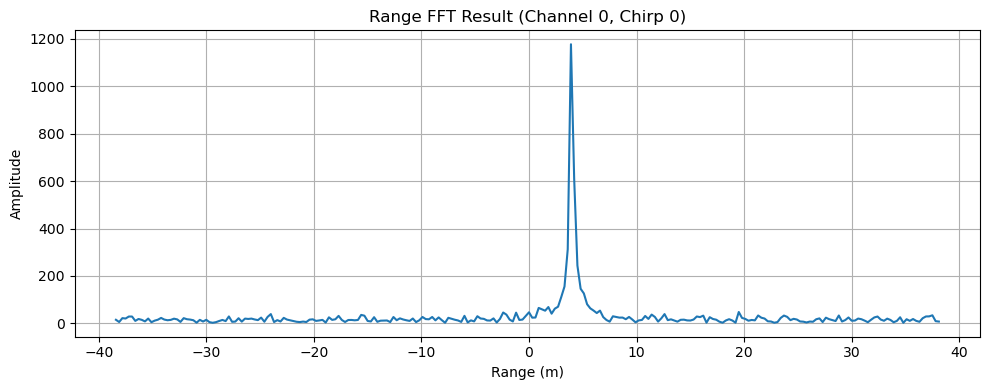

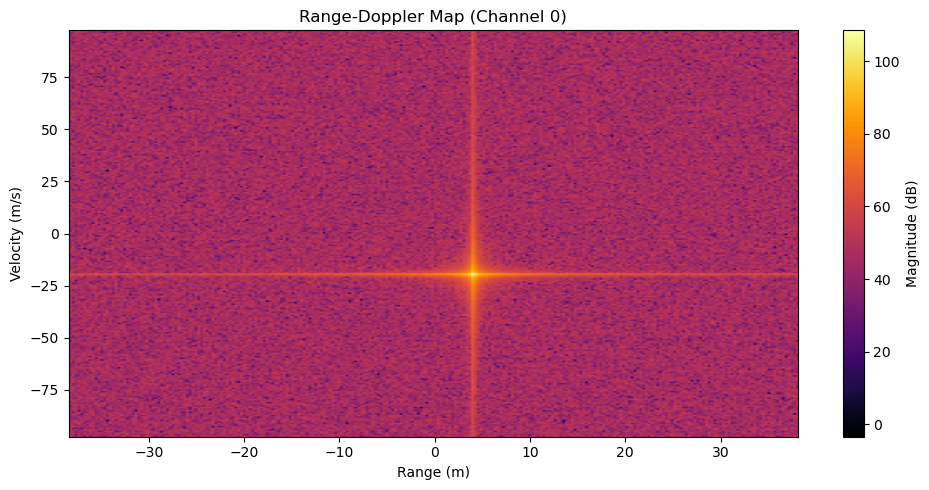

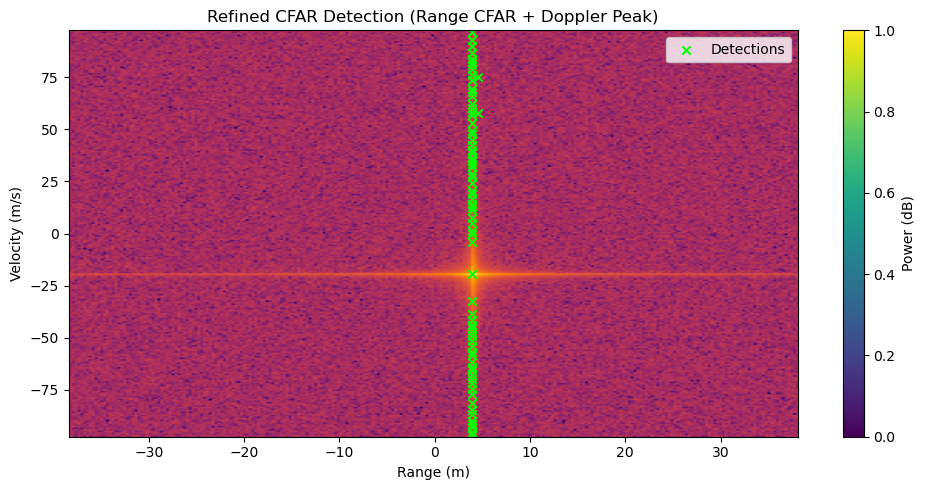

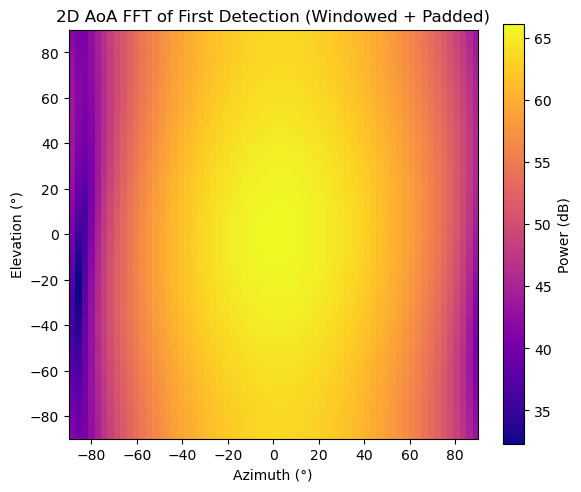

[[ 0.06189696  3.89901738 -0.06190476]
 [ 0.06189696  3.89901738 -0.06190476]
 [ 0.18569089  3.89508494  0.06190476]
 [ 0.18569089  3.89508494  0.06190476]
 [-0.18569089  3.89508494  0.06190476]
 [ 0.06189696  3.89901738  0.06190476]
 [ 0.06189696  3.89901738  0.06190476]
 [-0.06183454  3.89508494 -0.18571429]
 [ 0.06170949  3.88720812  0.30952381]
 [-0.06189696  3.89901738  0.06190476]
 [ 0.18569089  3.89508494  0.06190476]
 [-0.06189696  3.89901738 -0.06190476]
 [-0.06189696  3.89901738  0.06190476]
 [ 0.06183454  3.89508494  0.18571429]
 [-0.06189696  3.89901738  0.06190476]
 [ 0.06189696  3.89901738  0.06190476]
 [-0.06189696  3.89901738  0.06190476]
 [ 0.18550361  3.89115646 -0.18571429]
 [ 0.06189696  3.89901738  0.06190476]
 [ 0.18569089  3.89508494  0.06190476]
 [ 0.43327874  3.87536286 -0.06190476]
 [ 0.06183454  3.89508494  0.18571429]
 [ 0.06189696  3.89901738  0.06190476]
 [-0.06189696  3.89901738  0.06190476]
 [-0.06189696  3.89901738  0.06190476]
 [ 0.18569089  3.89508494

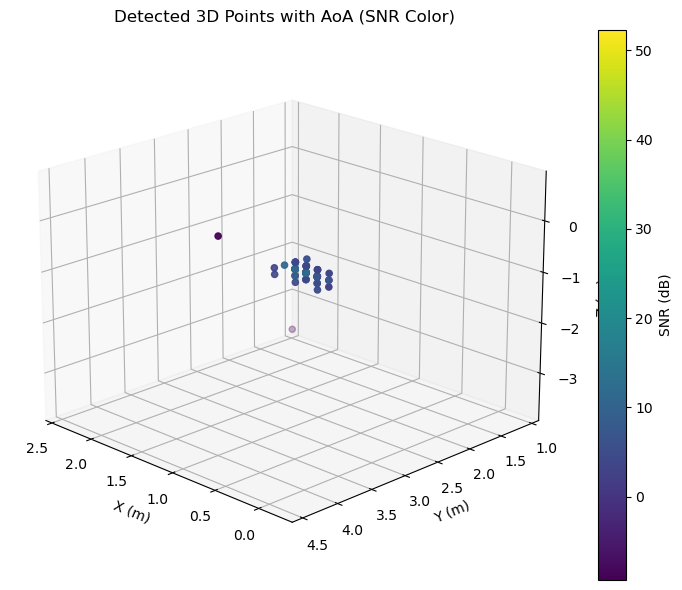

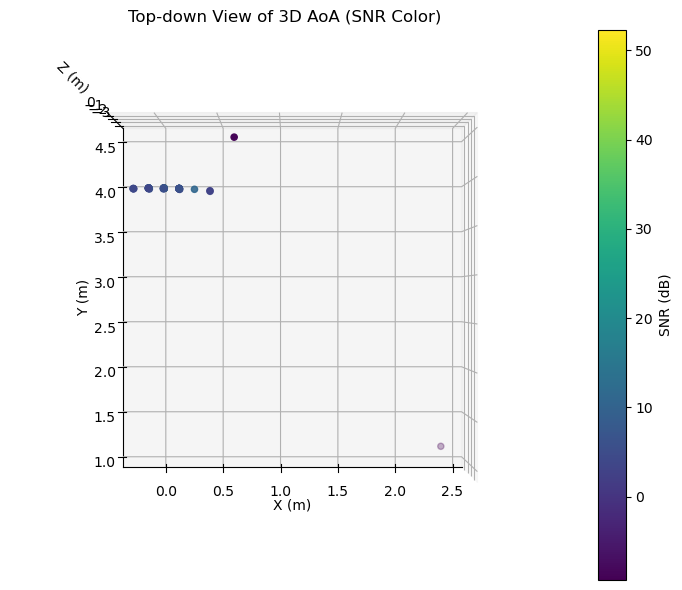

In [55]:
adc_data, _ = generate_adc_data(R=4, vx=0, vy=-20)
range_cube = range_fft(adc_data)
doppler_cube = doppler_fft(range_cube)
rd_power = np.abs(doppler_cube[0])**2
sorted_points = cfar_detect(rd_power)
angle_maps, snrs, angles = aoa_fft(doppler_cube, sorted_points)
plot_3d_with_snr(angle_maps, sorted_points, angles, snrs)

In [26]:
xyz_points

NameError: name 'xyz_points' is not defined

In [25]:
df_points[df_points['SNR (dB)'] > 8]

NameError: name 'df_points' is not defined

In [244]:
df_points

X (m)     Y (m)  Range (m)  Azimuth (deg)  Elevation (deg)   SNR (dB)  \
0   1.862945  1.994801        3.9      43.042423        45.584691   5.608184   
1   2.122891  1.715555        3.9      51.057559        45.584691   6.834161   
2   1.862945  1.994801        3.9      43.042423        45.584691   7.852629   
3   1.949594  1.910204        3.9      45.584691        45.584691   6.765136   
4   1.855036  1.817557        3.9      45.584691        48.247795   7.714152   
..       ...       ...        ...            ...              ...        ...   
70  1.862945  1.994801        3.9      43.042423        45.584691   9.966093   
71  1.937482  1.729403        3.9      48.247795        48.247795   9.237451   
72  2.036242  1.817557        3.9      48.247795        45.584691   9.600557   
73  1.937482  1.729403        3.9      48.247795        48.247795  12.975967   
74  1.840722  2.147496        4.5      40.601466        51.057559  -5.012983   

    Velocity (m/s)  
0        -13.69724  
1        -13.69724  
2        -13.69724  
3        -13.69724  
4        -13.69724  
..             ...  
70       -13.69724  
71       -13.69724  
72       -13.69724  
73       -13.69724  
74       -13.69724  

[75 rows x 7 columns]

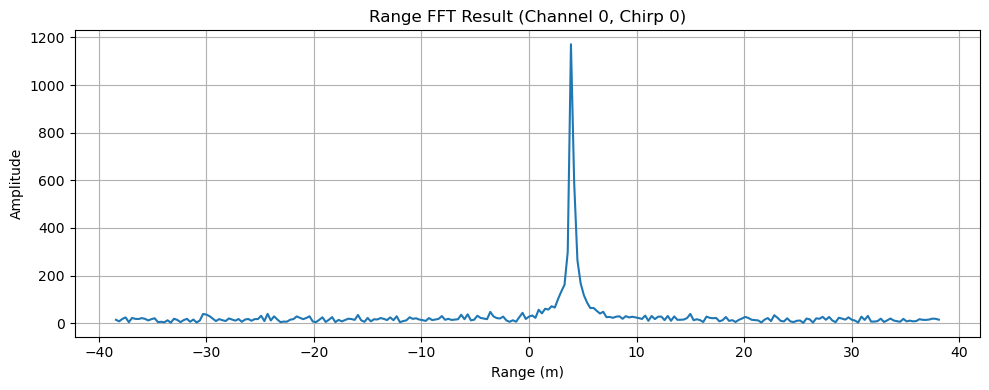

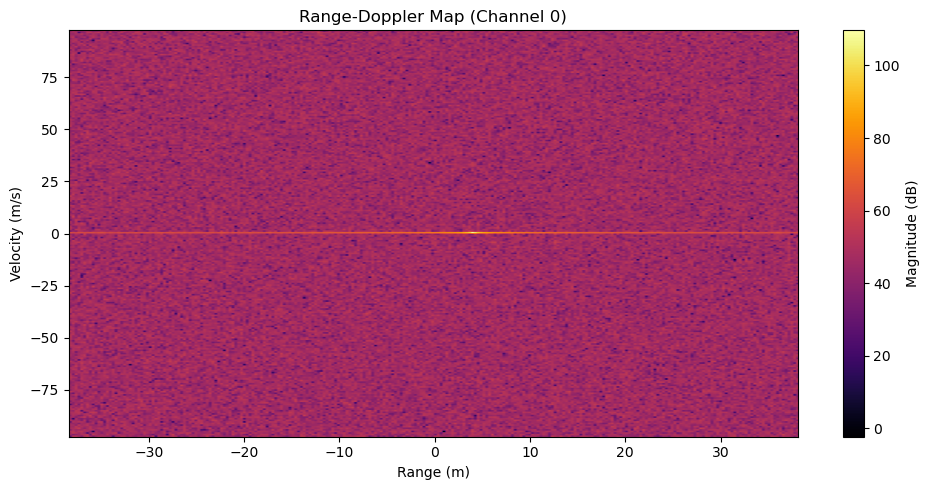

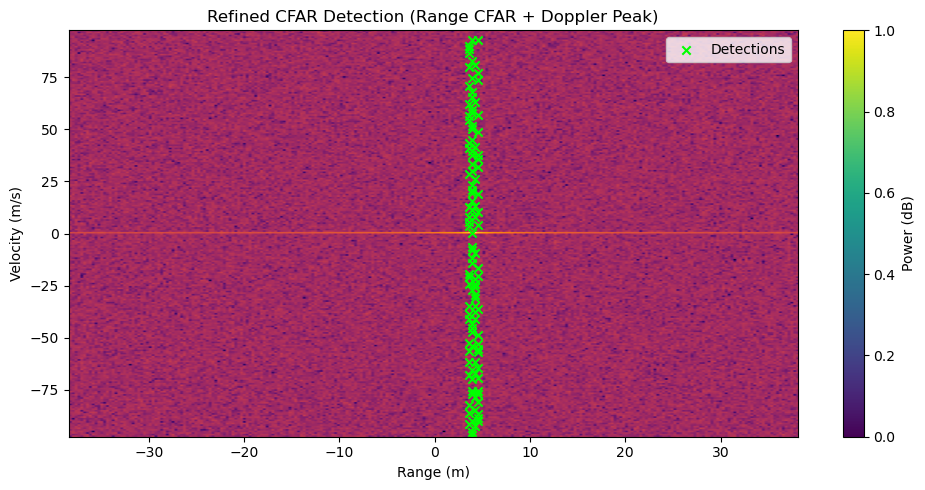

TypeError: 'numpy.ndarray' object is not callable

In [44]:
# 將所有步驟串起來的主控函式（可選擇性使用）
def fmcw_full_pipeline(R=4, vx=-20, vy=10):
    adc_data, theta = generate_adc_data(R, vx, vy)
    range_cube = range_fft(adc_data)
    doppler_cube = doppler_fft(range_cube)
    rd_power = np.abs(doppler_cube[0])**2
    sorted_points = cfar_detect(rd_power)
    angle_maps, mags, angles = aoa_fft(doppler_cube, sorted_points)
    xyz_points, ranges = angle_to_xyz(angle_maps, sorted_points, angles)
    velocities = estimate_velocity(adc_data, sorted_points)
    snrs_refined = calculate_refined_snr(doppler_cube, sorted_points)
    df = pd.DataFrame({
        "X (m)": xyz_points[:, 0],
        "Y (m)": xyz_points[:, 1],
        "Z (m)": xyz_points[:, 2],
        "Velocity (m/s)": velocities,
        "SNR (dB)": snrs_refined,
        "Theta (deg)": [theta] * len(xyz_points)
    })
    return df

# 實際執行一次 pipeline
df_pipeline = fmcw_full_pipeline(R=4, vx=20, vy=0)
# tools.display_dataframe_to_user(name="Modular FMCW Pipeline Output", dataframe=df_pipeline)

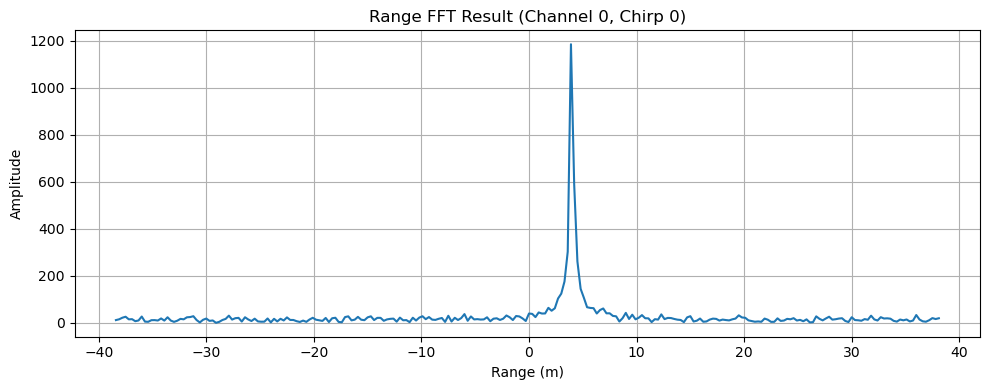

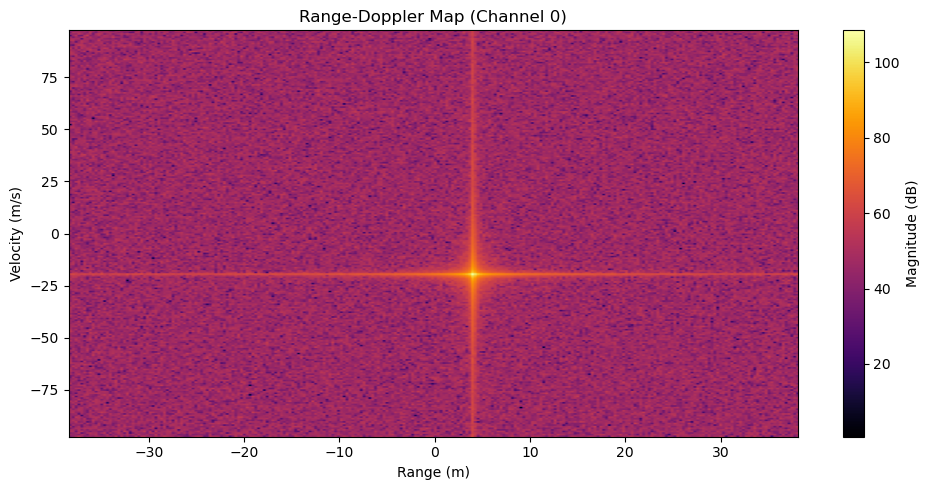

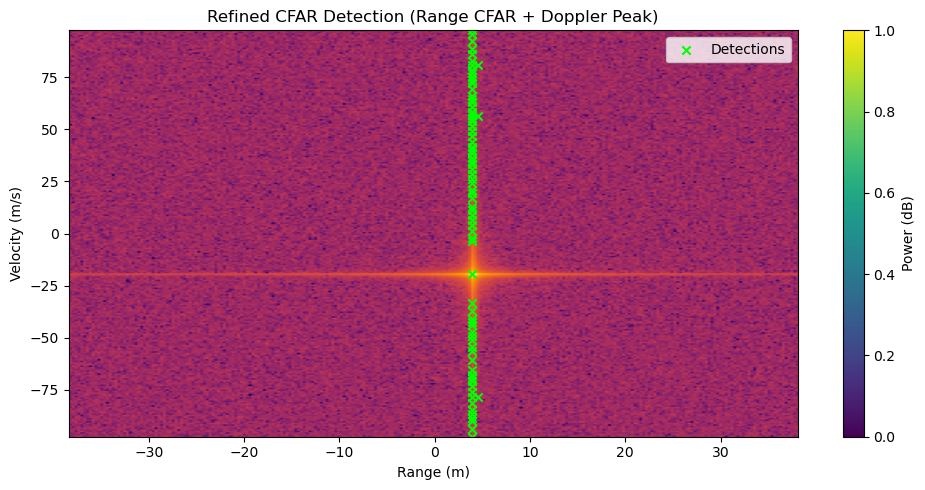

TypeError: 'numpy.ndarray' object is not callable

In [45]:
df_pipeline = fmcw_full_pipeline(R=4, vx = 0, vy=-20)
df_pipeline[df_pipeline['SNR (dB)'] > 5]

In [1]:
import numpy as np
a = np.load("adc_data.npy")
a.shape

(12, 256, 256)

In [12]:
a[0, :5, :5]

array([[ 5.1723967 -0.5209847j ,  5.7018943 +1.2166667j ,
         4.993827  +3.191513j  ,  3.2695448 +5.975531j  ,
         2.061527  +5.950295j  ],
       [ 2.9251544 -3.4826958j ,  5.8610463 -2.5338008j ,
         5.1115003 +0.21123014j,  5.783042  +2.8497653j ,
         4.2827373 +3.9165716j ],
       [ 1.5809262 -4.9423494j ,  2.1876683 -4.640017j  ,
         4.540305  -2.43773j   ,  5.576614  -2.667242j  ,
         7.297528  -0.05847364j],
       [-3.0028002 -6.7767234j , -0.7692899 -6.2495728j ,
         2.2425232 -4.256856j  ,  2.8275921 -3.2973278j ,
         4.459549  -4.362795j  ],
       [-4.75379   -4.107014j  , -2.9152482 -4.559293j  ,
        -1.9616967 -5.849144j  , -0.78163123-5.042873j  ,
         1.1235029 -4.3120017j ]], dtype=complex64)